# BoardGameGeek Content-based Recommender Data Pipeline

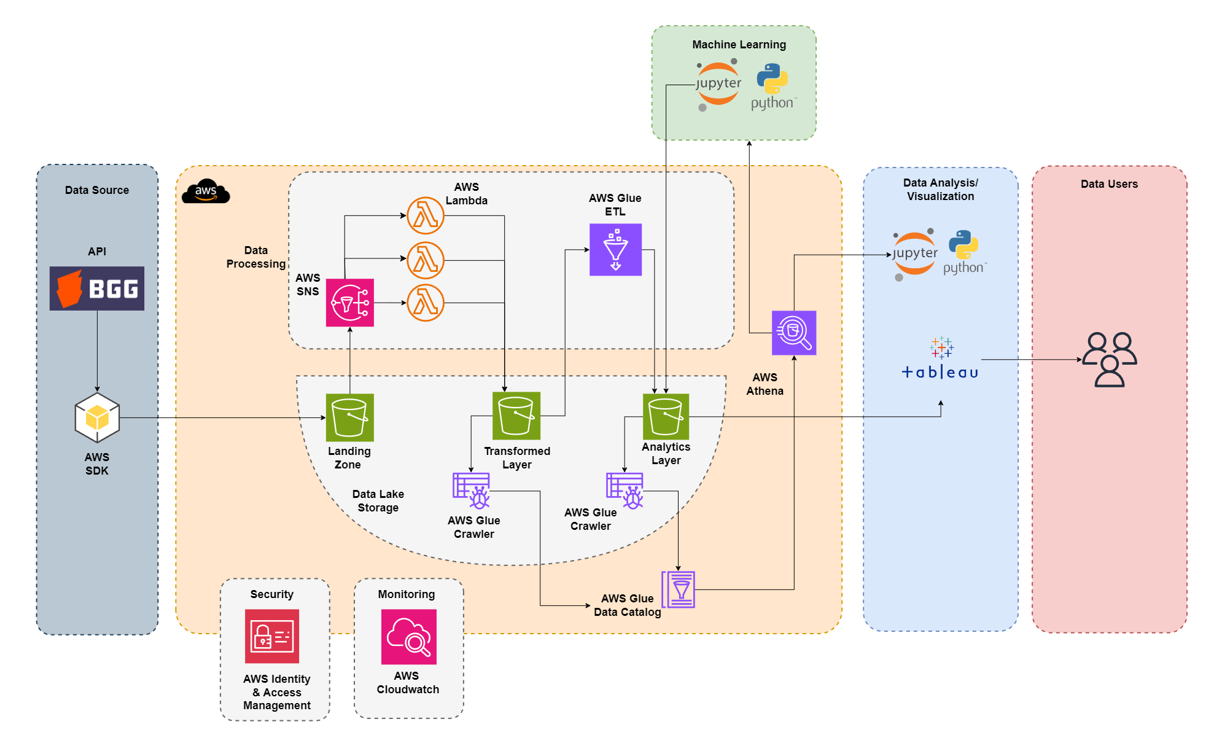

## Introduction

The remarkable growth of board gaming industry has created a dynamic landscape where players, ranging from new comers up to board game collectors, are now presented with an array of options for their next gaming adventure. From this growing consumer interest, innovative game designs, and social interaction that board gaming promotes, it is projected that this industry will still further grow in the coming years. In retrospect, everyone of us has played some type of board game whether the timeless monopoly or even a simple game of checkers, we always found ourselves wanting to try more games that surely piques our interest. Thus, this project is geared towards in creating a board game recommender model leveraging the extensive database of **BoardGameGeek (BGG)**, a longstanding platform for board game reviews with an already established community of board game enthusiasts.

The objective of this project is to establish a comprehensive data pipeline spanning from data collection to dashboard visualization. The depicted system architecture, detailed above, emphasizes the utilization of **Amazon Web Services (AWS)** cloud tools for data processing. This notebook delves into the tools utilized in pipeline development, along with alternative architectures and processes explored during the project's execution. It's essential to note that the primary objective of this project is to explore the potential of cloud technologies in executing data projects, prioritizing exploration over cost efficiency. Nonetheless, the ensuing discussion on data architecture will offer a thorough examination of cloud technologies' capabilities in creating complete data pipelines.

## Data Source

The [BGG API documentation](https://boardgamegeek.com/wiki/page/BGG_XML_API2) provides the endpoints that developers may use in obtaining board game features from board game content up to statistics of ratings and complexity, as reviewed by BGG users. The API returns a *semi-structured* XML data format that contains tags, similar to an HTML tag, to categorize the data. An example of an API response is shown below.

```
<items termsofuse="https://boardgamegeek.com/xmlapi/termsofuse">
    <item type="boardgame" id="237182">
        <thumbnail>https://cf.geekdo-images.com/JU...</thumbnail>
        <image>https://cf.geekdo-images.com/JU...</image>
        <name type="primary" sortindex="1" value="Root"/>
        <name type="alternate" sortindex="1" value="Root: A Game of Woodland Might and Right"/>
        <description>Root is a game of ...</description>
        <yearpublished value="2018"/>
        <minplayers value="2"/>
        <maxplayers value="4"/>
        <poll name="suggested_numplayers" title="User Suggested Number of Players" totalvotes="982">
            <results numplayers="1">
                <result value="Best" numvotes="3"/>
                <result value="Recommended" numvotes="78"/>
                <result value="Not Recommended" numvotes="592"/>
            </results>
        <link type="boardgamecategory" id="1086" value="Territory Building"/>
        <link type="boardgamecategory" id="1019" value="Wargame"/>
        <link type="boardgamemechanic" id="2689" value="Action Queue"/>
        <link type="boardgamemechanic" id="2839" value="Action Retrieval"/>
    </item>
</items>
```

The semi-structured format of the response requires further parsing and flattening before any data consumption is initiated. It is also worth mentioning that web scraping is another option to obtain the information from the BGG website. The downside of scraping from using the API is that the scraping process of 150,000+ board games may be slow which is why attempts in the past tries to limit the scraping process to the top 5000 or 10,000 board games. This project will only scrape the unique identifier (`bgg_id`) of all board games but will obtain all information about the board game using the API. This way, the scraping will only be limited to the ~1,500 pages of the ['browse board game'](https://boardgamegeek.com/browse/boardgame) web page of BGG instead of visiting all 150,000 web pages of board game collections.

## Data Storage

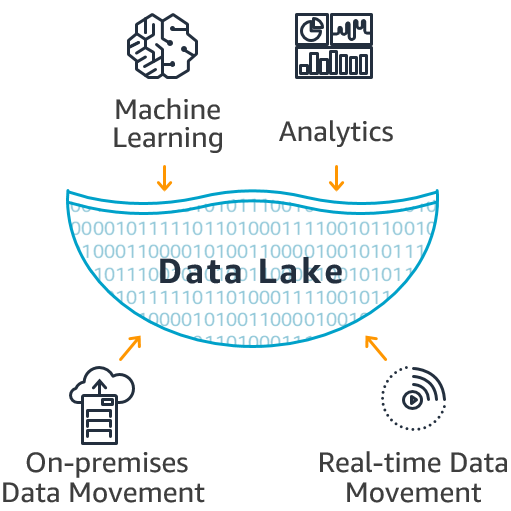

A data lake is a centralized repository that accepts all types of data from unstructured (text documents, images, videos), semi-structured (JSON, XML), and structured (csv, relational datababse data) data. Unlike data warehouses, data lake can receive schema-less data which are stored in data sinks that may or may not be transformed. In the above diagram, the data lake consists of three AWS S3 buckets namely, Landing Zone, Transformed Layer, and Analytics Layer. 
* Landing Zone - receives the raw XML file from the BGG API.
* Transformed Layer - stores the flattened XML files where EDA data will be extracted.
* Analytics Layer - serves as the final location where data for visualizations will be obtained.

Moreover, *data partitioning* is used as the data modelling technique used to access the data in the S3 buckets. Similar to the Data Warehousing, the partitioning of your data will depend on the business objectives and the pattern by which data is accessed, but a commonly used partition is the *date* of storage. Since data lakes are particularly designed to handle big data, the partitioning strategy plays a vital roles in quickly accessing portions of data to avoid scanning terrabytes worth of data. 

In this project, data partitioning is implemented based on two key factors: the *date* of API call and the *type* of table (details, classification, poll) being stored. The date partitioning enables the data to be segmented according to the extraction date, allowing the pipeline to fetch historical data, if needed. BGG typically provides historical ranks for specific board games, but this pipeline extends historical tracking to all recommendation features.

Additionally, the type of table denotes the specific information stored within each table:
- The *details* table encompasses all features and statistics associated with board games.
- The *classification* table houses characteristics such as mechanics, categories, and families that define board games.
- The *poll* table contains community-driven survey responses, including suggested minimum player age and the number of players recommended for a particular board game.

By partitioning the data based on both date and table type, the pipeline can efficiently manage and organize the vast amount of board game data obtained from the BGG API. This partitioning strategy enables scalability, facilitates historical data retrieval, and enhances the overall effectiveness of the recommendation system.

## Data Processing

As mentioned earlier, flattening of the the XML file is required in order to consume the data for analysis or machine learning. Three XML flattening techniques were considered in this project:
1. Using custom classifiers in AWS Glue Crawlers
2. Using AWS Glue PySpark `.relationalize()`
3. Using AWS Lambda and Python libraries for parsing the XML files

Each of this methods will be discussed in the succeeding sections including the tools involved in their development.

### AWS Glue

AWS Glue is an AWS service used for managing serverless  ETL (extract, transform, load) pipelines that runs Apache Spark under the hood. The simplified process of building and managing pipelines allows developers to automate solutions from data ingest up to storage. Key tools that AWS Glue offers are *Data Crawlers and Classifiers*, *Data Catalogs*, *Visual ETLs*, *Workflow Scheduling*, and *Interactive notebooks*.

#### Data Crawlers and Catalog

Each time a batch of data is ingested into an S3 bucket, a data crawler can automatically read its schema to store its metadata in the AWS Glue Data Catalog. The metadata allows for AWS Athena to query the dataset using SQL-like syntax for data retrieval. The figure below shows the schema of `bgg_analytics_details` obtained from automatic crawling of the dataset whenever the data goes from transformed layer up to analytics layers. 

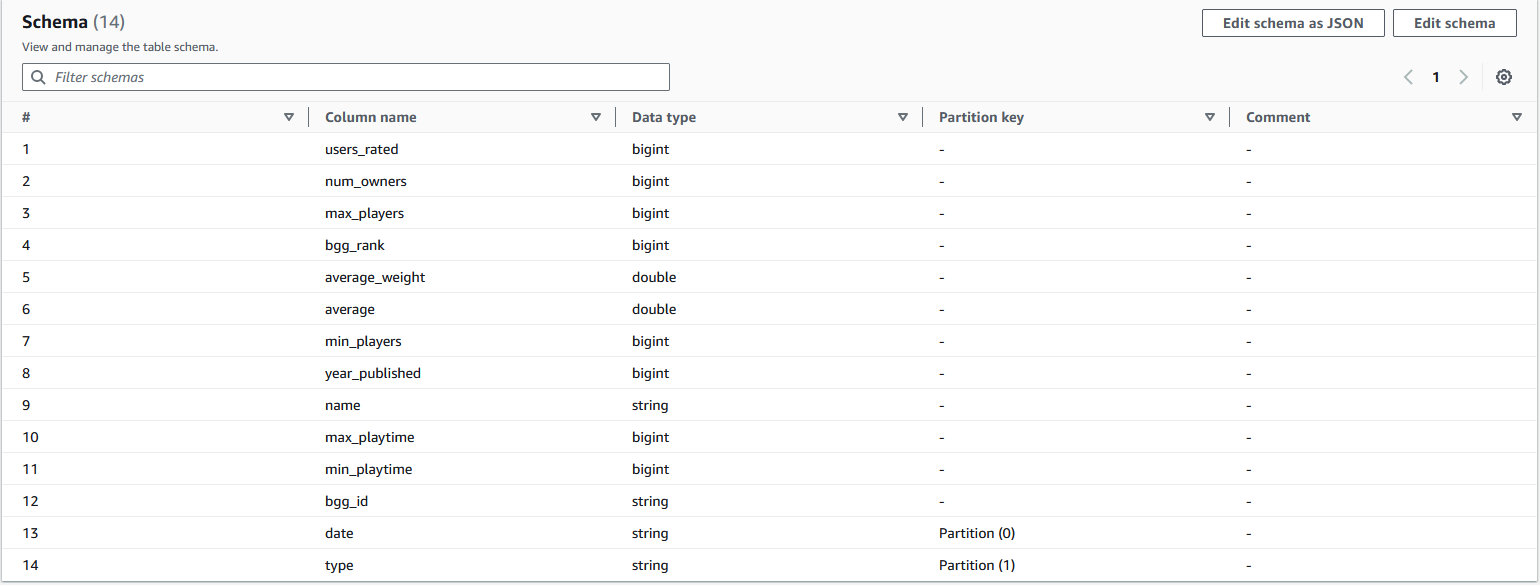

#### Classifiers

For semi-structured data like an XML file, *custom classifiers* are needed to handle file formats beyond the built-in classifiers (CSV, JSON, Parquet, and ORC). For XML files, the *row tag* is selected to determine which of the tags in the XML file will be considered as one row in a table. In the example of a response from BGG API, the `<item>` tag is selected as the row tag in the custom classifier since the rows in the flattened table should refer to one board game per row as identified by their `bgg_id` (e.g. `id="237182"`). The created custom classifier and the resulting data catalog is shown in below:

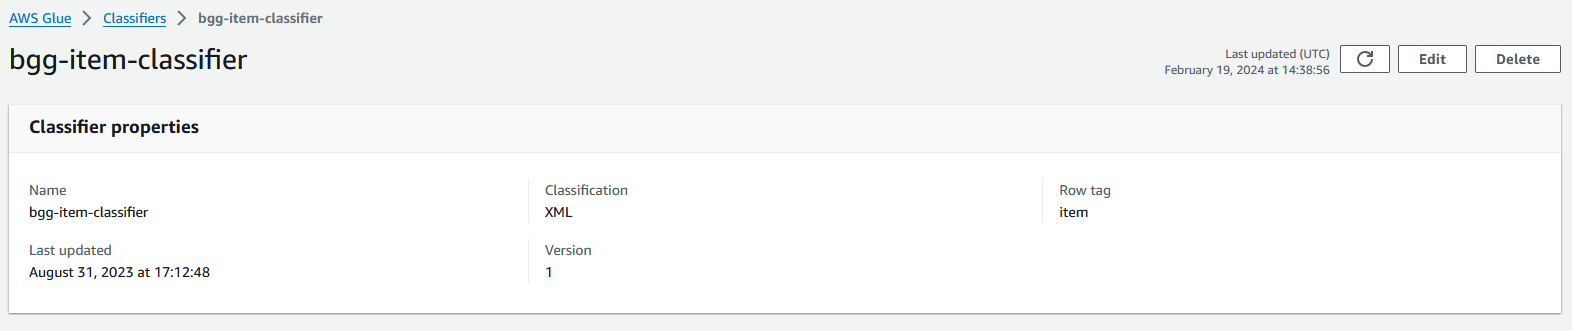

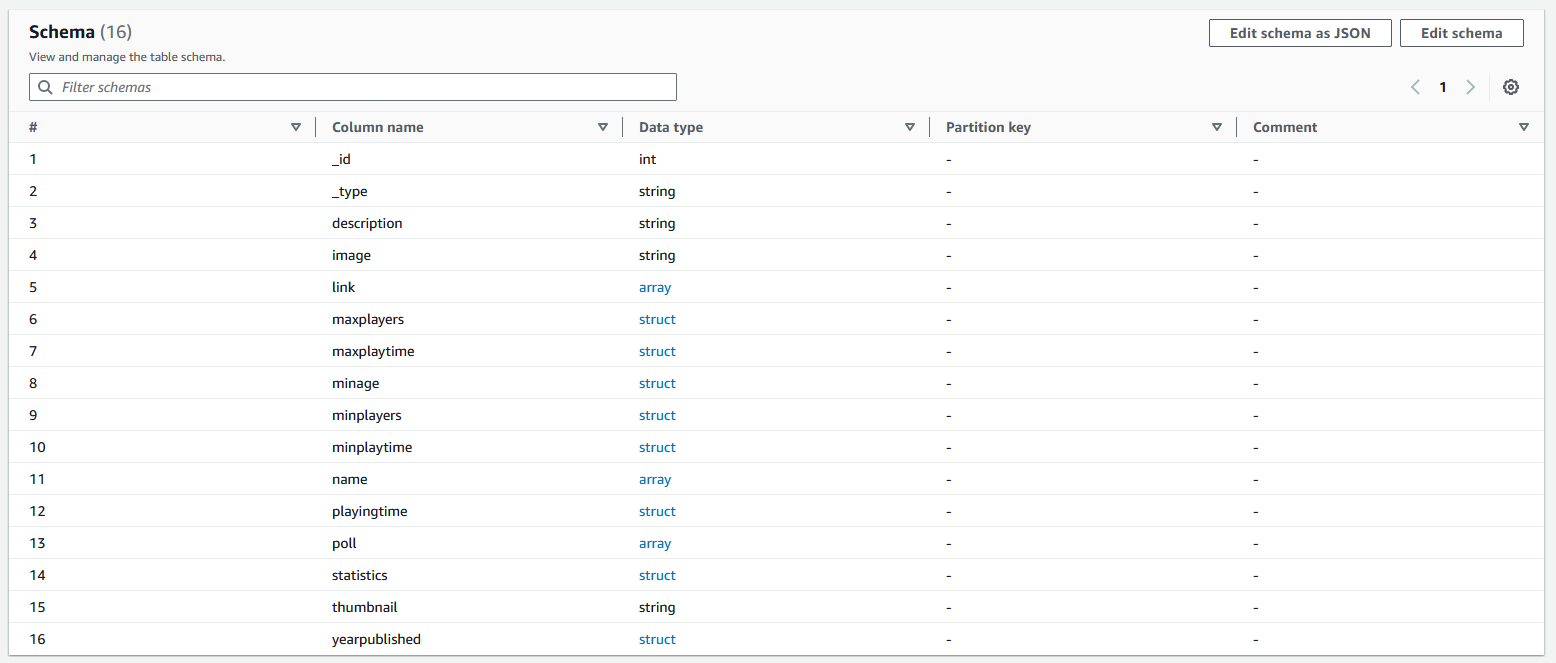

As shown, the data crawler successfully processed the XML file, generating a table with columns such as `image`, `maxplayers`, `playingtime`, and others. However, employing custom classifiers presents a drawback: semi-structured data often contains multiple nested layers, leading to the resulting schema including columns with a `struct` data type. This signifies that these columns still contain nested data as values, potentially resulting in data loss as users might not readily know which data remains within these nested columns based solely on metadata inspection. Thus, this method was not pursued due to the potential data loss when inferring the schema.

#### Interactive Notebooks

AWS Glue Studio provides an interactive session based on Jupyter Notebooks where developers can prototype their job scripts before releasing to production. In this project, the PySpark transform method named `.relationalize()` was used as it allows for a quick transformation of nested data into flattened tables. The method will make use of the initial schema developed from using custom classifiers and the XML file will be flattened into multiple tables that can easily be joined using the respective keys of each table. The full implementation of the Glue Studio Notebook can be located in the `notebooks` folder of this repository. The following codes show a snippet of the PySpark code after initialization of the workers:

```python
bggdf = glueContext.create_dynamic_frame.from_catalog(database="bgg-database", table_name="bgg_raw_xml_data_test")
bggdf.printSchema()
```

```
root
|-- _id: int
|-- _type: string
|-- description: string
|-- image: string
|-- link: array
|    |-- element: struct
|    |    |-- _VALUE: null
|    |    |-- _id: int
|    |    |-- _inbound: boolean
|    |    |-- _type: string
|    |    |-- _value: string
|-- maxplayers: struct
|    |-- _VALUE: null
|    |-- _value: int
|-- maxplaytime: struct
|    |-- _VALUE: null
|    |-- _value: int
|-- minage: struct
|    |-- _VALUE: null
|    |-- _value: int
|-- minplayers: struct
|    |-- _VALUE: null
|    |-- _value: int
|-- minplaytime: struct
|    |-- _VALUE: null
|    |-- _value: int
|-- name: choice
|    |-- array
|    |    |-- element: struct
|    |    |    |-- _VALUE: null
|    |    |    |-- _sortindex: int
|    |    |    |-- _type: string
|    |    |    |-- _value: string
|    |-- struct
|    |    |-- _VALUE: null
|    |    |-- _sortindex: int
|    |    |-- _type: string
|    |    |-- _value: string
|-- playingtime: struct
|    |-- _VALUE: null
|    |-- _value: int
|-- poll: array
|    |-- element: struct
|    |    |-- _name: string
|    |    |-- _title: string
|    |    |-- _totalvotes: int
|    |    |-- results: array
|    |    |    |-- element: struct
|    |    |    |    |-- _numplayers: string
|    |    |    |    |-- result: array
|    |    |    |    |    |-- element: struct
|    |    |    |    |    |    |-- _VALUE: null
|    |    |    |    |    |    |-- _level: int
|    |    |    |    |    |    |-- _numvotes: int
|    |    |    |    |    |    |-- _value: string
|-- statistics: struct
|    |-- _page: int
|    |-- ratings: struct
|    |    |-- average: struct
|    |    |    |-- _VALUE: null
|    |    |    |-- _value: double
|    |    |-- averageweight: struct
|    |    |    |-- _VALUE: null
|    |    |    |-- _value: choice
|    |    |    |    |-- double
|    |    |    |    |-- int
|    |    |-- bayesaverage: struct
|    |    |    |-- _VALUE: null
|    |    |    |-- _value: double
|    |    |-- median: struct
|    |    |    |-- _VALUE: null
|    |    |    |-- _value: int
|    |    |-- numcomments: struct
|    |    |    |-- _VALUE: null
|    |    |    |-- _value: int
|    |    |-- numweights: struct
|    |    |    |-- _VALUE: null
|    |    |    |-- _value: int
|    |    |-- owned: struct
|    |    |    |-- _VALUE: null
|    |    |    |-- _value: int
|    |    |-- ranks: struct
|    |    |    |-- rank: array
|    |    |    |    |-- element: struct
|    |    |    |    |    |-- _VALUE: null
|    |    |    |    |    |-- _bayesaverage: double
|    |    |    |    |    |-- _friendlyname: string
|    |    |    |    |    |-- _id: int
|    |    |    |    |    |-- _name: string
|    |    |    |    |    |-- _type: string
|    |    |    |    |    |-- _value: int
|    |    |-- stddev: struct
|    |    |    |-- _VALUE: null
|    |    |    |-- _value: double
|    |    |-- trading: struct
|    |    |    |-- _VALUE: null
|    |    |    |-- _value: int
|    |    |-- usersrated: struct
|    |    |    |-- _VALUE: null
|    |    |    |-- _value: int
|    |    |-- wanting: struct
|    |    |    |-- _VALUE: null
|    |    |    |-- _value: int
|    |    |-- wishing: struct
|    |    |    |-- _VALUE: null
|    |    |    |-- _value: int
|-- thumbnail: string
|-- yearpublished: struct
|    |-- _VALUE: null
|    |-- _value: int
```

Flattening the schema above will result in seven tables using the `.relationalize()` method call.

```python
bgg_relationalize = bggdf.relationalize("root", "s3://bgg-raw-xml-data-test/glue_relationalize/")
bgg_relationalize.keys()
```


The following tables are: 

```
dict_keys(['root', 'root_poll.val.results.val.result', 'root_poll.val.results', 'root_link', 'root_statistics.ratings.ranks.rank', 'root_name.array', 'root_poll'])
```

Viewing the schema of `root`:

```python
bggflatdf = bgg_relationalize.select("root")
bggflatdf.printSchema()
```

```
root
|-- _id: int
|-- _type: string
|-- description: string
|-- image: string
|-- link: long
|-- maxplayers._VALUE: null
|-- maxplayers._value: int
|-- maxplaytime._VALUE: null
|-- maxplaytime._value: int
|-- minage._VALUE: null
|-- minage._value: int
|-- minplayers._VALUE: null
|-- minplayers._value: int
|-- minplaytime._VALUE: null
|-- minplaytime._value: int
|-- name.array: long
|-- name.struct._VALUE: null
|-- name.struct._sortindex: int
|-- name.struct._type: string
|-- name.struct._value: string
|-- playingtime._VALUE: null
|-- playingtime._value: int
|-- poll: long
|-- statistics._page: int
|-- statistics.ratings.average._VALUE: null
|-- statistics.ratings.average._value: double
|-- statistics.ratings.averageweight._VALUE: null
|-- statistics.ratings.averageweight._value.double: double
|-- statistics.ratings.averageweight._value.int: int
|-- statistics.ratings.bayesaverage._VALUE: null
|-- statistics.ratings.bayesaverage._value: double
|-- statistics.ratings.median._VALUE: null
|-- statistics.ratings.median._value: int
|-- statistics.ratings.numcomments._VALUE: null
|-- statistics.ratings.numcomments._value: int
|-- statistics.ratings.numweights._VALUE: null
|-- statistics.ratings.numweights._value: int
|-- statistics.ratings.owned._VALUE: null
|-- statistics.ratings.owned._value: int
|-- statistics.ratings.ranks.rank: long
|-- statistics.ratings.stddev._VALUE: null
|-- statistics.ratings.stddev._value: double
|-- statistics.ratings.trading._VALUE: null
|-- statistics.ratings.trading._value: int
|-- statistics.ratings.usersrated._VALUE: null
|-- statistics.ratings.usersrated._value: int
|-- statistics.ratings.wanting._VALUE: null
|-- statistics.ratings.wanting._value: int
|-- statistics.ratings.wishing._VALUE: null
|-- statistics.ratings.wishing._value: int
|-- thumbnail: string
|-- yearpublished._VALUE: null
|-- yearpublished._value: int
```

As anticipated, the previously nested schema has been successfully flattened into a single-level DynamicFrame, as depicted in the schema above. While there are additional processing steps required for the DynamicFrames, the challenging task of flattening the tables has been seamlessly completed with just a single call in PySpark. Each table maintains its own schema, allowing for straightforward joins and enabling flexibility for further operations as necessary.

The drawback of employing this approach lies in the expenses incurred by executing the job script, in contrast to a more economical alternative that will be detailed in the subsequent method. The Glue job referenced above utilized 2 G.1X worker type, totaling 2 DPUs (Data Processing Units), which AWS bills at \$0.44 per DPU-hour. While this cost may initially appear small at first, this can easily compound depending if increased number of workers are required or more processing time is needed. XML files are delivered to the S3 landing zone in batches, triggering automatic Glue jobs to transform these files. Consequently, this method was not pursued due to the significant costs involved.

### AWS Lambda

AWS Lambda is a serverless service capable of executing code automatically in response to events, with the ability to effortlessly scale based on workload demands. Additionally, it stands out as a cost-effective solution due to AWS providing 1 million free requests per month, with subsequent requests billed at a highly reasonable rate. The downside of using AWS Lambda over AWS Glue is its high upfront development effort to parse the XML using Python libraries. Nonetheless, it's important to highlight that utilizing AWS Lambda didn't result in any expenses, as all script executions fell within the monthly free tier. AWS Lambda imposes a maximum timeout period of 15 minutes, and if tasks like data processing exceed this limit, developers must resort to alternative solutions such as AWS Glue.

The lambda python codes can be found in the `src` folder in this repository named `lambda_details.py`, `lambda_classification.py`, and `lambda_poll.py`. 

Notable libraries used in the lambda python scripts are:
* [xml.etree.ElementTree](https://docs.python.org/3/library/xml.etree.elementtree.html) - python library for parsing XML files.
* [awswrangler](https://aws-sdk-pandas.readthedocs.io/en/stable/) - equivalent *pandas* library in the AWS.
* [boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html) - AWS API to configure and manage AWS services.

The structure of the scripts can be broken down into four parts:

#### 1. Loading libraries and environment variables

In this step, variables such as the output path for s3, glue database and table name for the data crawlers, and partitions are defined. The use of environment variables shown below allows the developer to make future updates easily without requiring to redeploy the code in AWS Lambda.

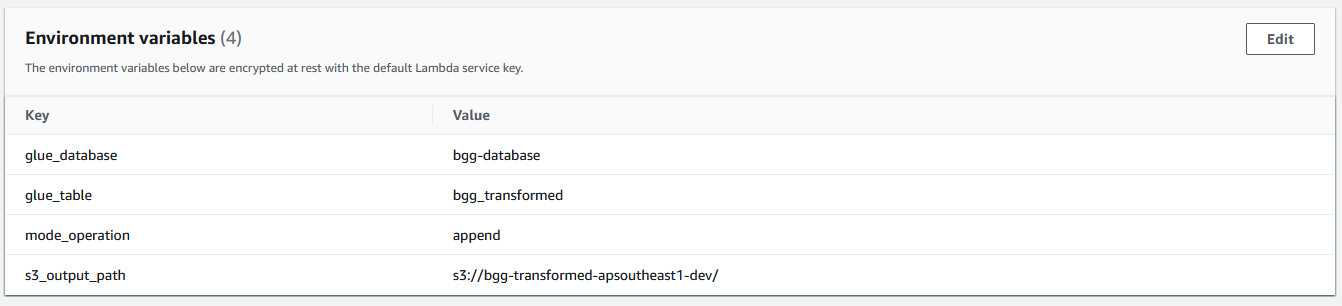

S3 client is also initialized using `boto3` at this stage to retrieve the XML from the S3 Landing Zone. 

#### 2. Read the `event` json file and obtain the s3 bucket location for the XML files.

The `event` parameter in the `lambda_handler()` function holds the json file containing the details of the event trigger. An example of an event json is shown below.

```
{
  "Records": [
    {
      "eventVersion": "2.0",
      "eventSource": "aws:s3",
      "awsRegion": "us-east-1",
      "eventTime": "1970-01-01T00:00:00.000Z",
      "eventName": "ObjectCreated:Put",
      "userIdentity": {
        "principalId": "EXAMPLE"
      },
      "requestParameters": {
        "sourceIPAddress": "127.0.0.1"
      },
      "responseElements": {
        "x-amz-request-id": "EXAMPLE123456789",
        "x-amz-id-2": "EXAMPLE123/5678abcdefghijklambdaisawesome/mnopqrstuvwxyzABCDEFGH"
      },
      "s3": {
        "s3SchemaVersion": "1.0",
        "configurationId": "testConfigRule",
        "bucket": {
          "name": "bgg-raw-xml-data-test",
          "ownerIdentity": {
            "principalId": "EXAMPLE"
          },
          "arn": "arn:aws:s3:::example-bucket"
        },
        "object": {
          "key": "0-1200.xml",
          "size": 1024,
          "eTag": "0123456789abcdef0123456789abcdef",
          "sequencer": "0A1B2C3D4E5F678901"
        }
      }
    }
  ]
}
```

Parameters such as the s3 bucket name and key can be easily parsed from the json document. The XML files are then obtained using the initalized s3 client and using the method call `.get_object()`.

```python
s3_response = s3.get_object(Bucket=bucket, Key=key)
xml_data = s3_response['Body'].read().decode(encoding='utf-8')
```

#### 3. Parse the XML files using a user defined function.

Now that `xml_data` stores all the xml files for a specific batch, then the defined function can easily transform the semi-structured data into a more manageable one such as a pandas data frame. Separate lambda functions were defined for each table (details, classification, poll) since each row of the table represents a different granularity for each board game.  

#### 4. Store the flattened XML files as parquet in the transformed layer S3 bucket.

After flattening the XML file, `awswrangler` sends the data into the S3 transformed layer in a [parquet](https://parquet.apache.org/docs/) data format. In addition, `awswrangler` also triggers the data crawler to update the schema in the data catalog, when necessary, and to partition the dataset as defined in the first step. 

```python
wr_response = wr.s3.to_parquet(df=df_bgg,
                               path=s3_output_path,
                               dataset=True,
                               database=glue_database,
                               table=glue_table,
                               mode=mode_operation,
                               partition_cols=partitions)
```

In analytics contexts, columnar-oriented storage formats like Parquet offer a distinct advantage over row-based storage options such as CSV or TSV. This advantage lies in their ability to boost query performance by selectively reading only the relevant columns, a common requirement for analytics tasks. Additionally, Parquet's compression features facilitate substantial reductions in data storage requirements. 

### AWS Simple Notification Service (SNS)

Configuring S3 events to trigger Lambda functions for data transformations is straightforward. However, because the three Lambda functions are tasked with parsing XML files, an alternative architecture is necessary to trigger multiple Lambdas from a single S3 event. The *Fanout* pattern offered by AWS SNS accomplishes this by replicating messages published to a topic, which can then be distributed to multiple endpoints.

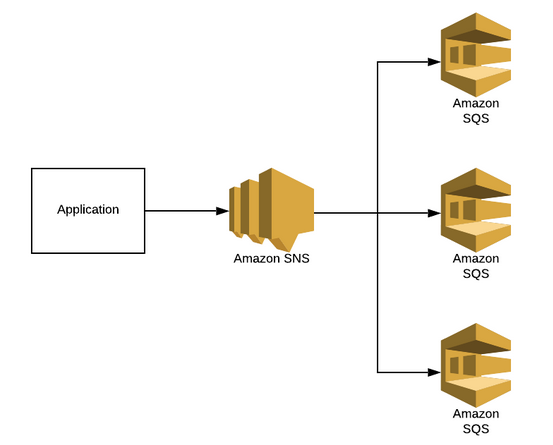

In our architecture, a single S3 event notification is sent to an SNS topic, which is replicated and routed to the respective Lambda functions.

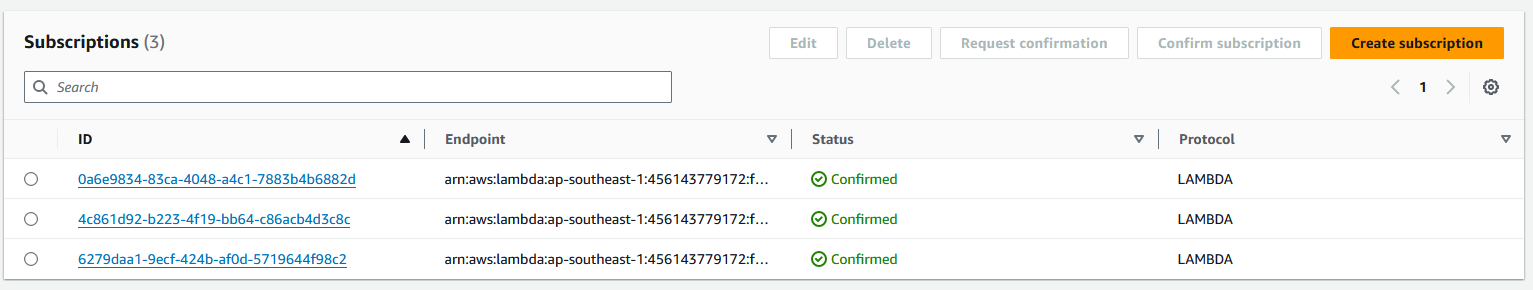

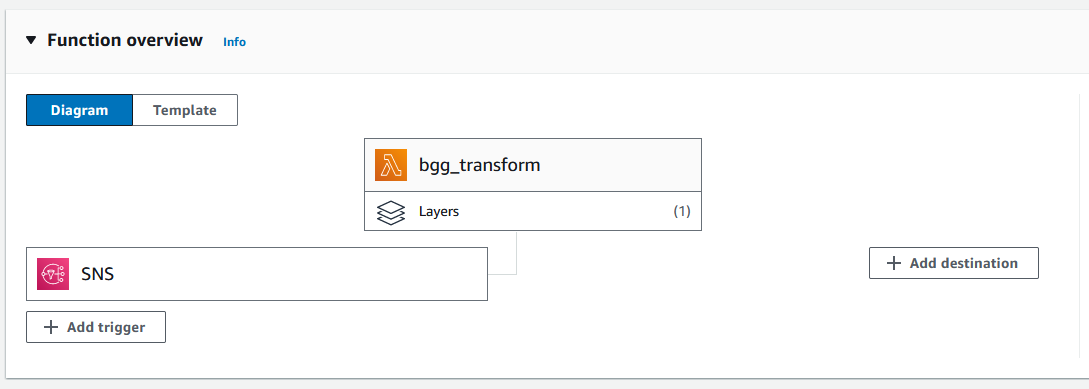

Hence, in the AWS Lambda parsing of the `event` parameter, the actual s3 event is contained inside the message sent by SNS which can be obtained using the following code:

```python
s3_event = json.loads(event['Records'][0]['Sns']['Message'])
```

### AWS Glue - Visual ETL

AWS Lambda is still the economical option to use for processing data from transformed layer to analytics layer but as mentioned earlier, the goal of this project is to explore the capabilities of using cloud technologies in creating data pipelines. Assuming that AWS Lambda is not capable of handling the data, an alternative service that AWS Glue Studio offers is the use of *Visual ETL* to create the data pipeline as shown below.

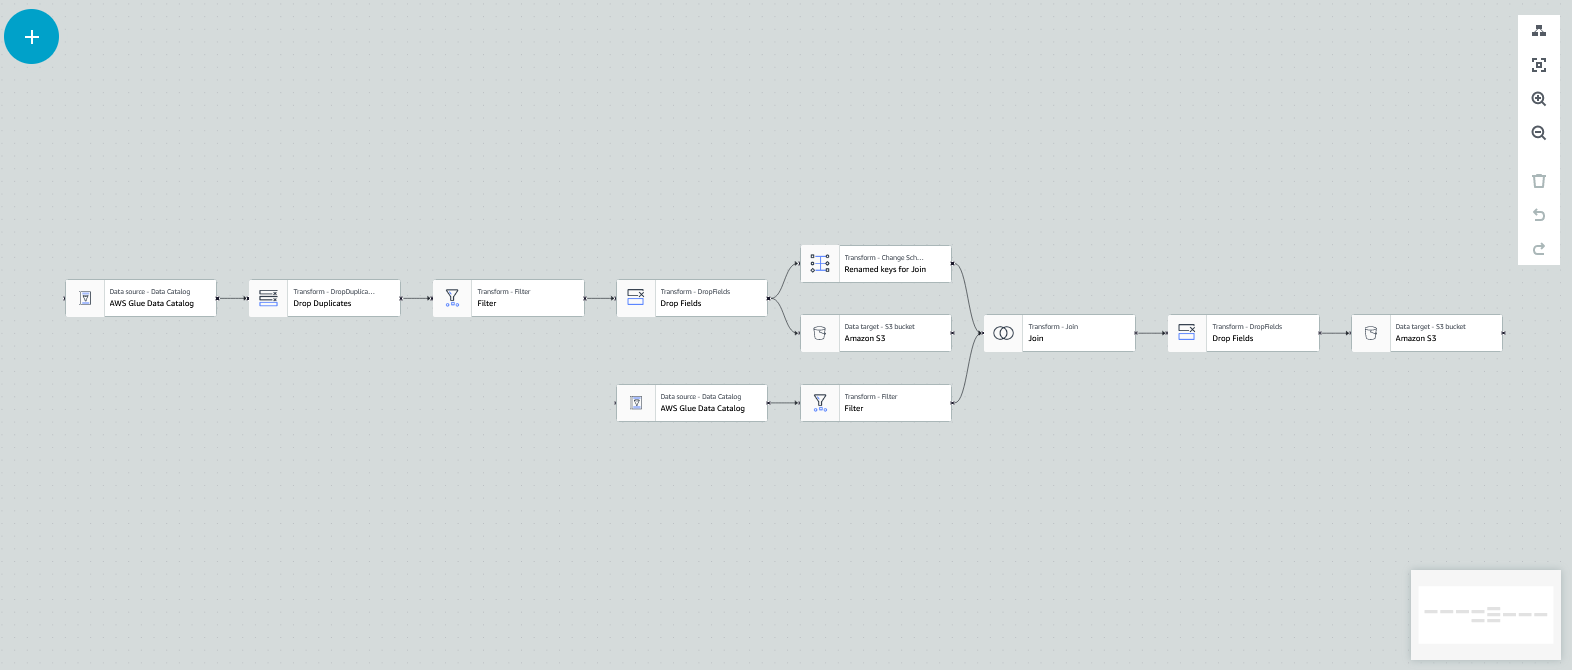

Most of the processing tasks, such as removing duplicates, filtering data, dropping columns, and merging two tables, can be effortlessly executed using AWS Glue's data flow interface. The nodes within this interface represent the transformation operations, offering a straightforward method for developing a Glue job script by simply configuring the presets in the nodes. In the depicted visual ETL process, the metadata of the transformed dataset is extracted from the Data Catalog, with additional transformations applied before proceeding to join the tables and eventually stored in the analytics layer. The primary objective behind establishing an analytics layer is to streamline data retrieval for visualization purposes, thereby simplifying the complexity of SQL queries and enhancing frontend performance within the data pipeline.

The ETL pipeline above was ran using 10 G.1X workers which completed in under 2 minutes. The resulting Glue job script is located in the `src` folder of this repository.

## Security and Monitoring

#### AWS Identity and Access Management (IAM)

To initialize AWS services using `boto3`, AWS Identity and Access Management (IAM) controls the permissions of the users that are allowed to perform operations in AWS. The principle of *least privileges* is always employed by assigning a user limited access rights to minimize potential misuse of privileges. In this project, a separate `bgg_user` is not assigned with any permission policies but rather assumes an IAM role set only to access S3 buckets and AWS Athena over a limited time period. The IAM role `bgg_user_role` only has a maximum duration of 8 hours to finish tasks regarding data collection or retrieval. 

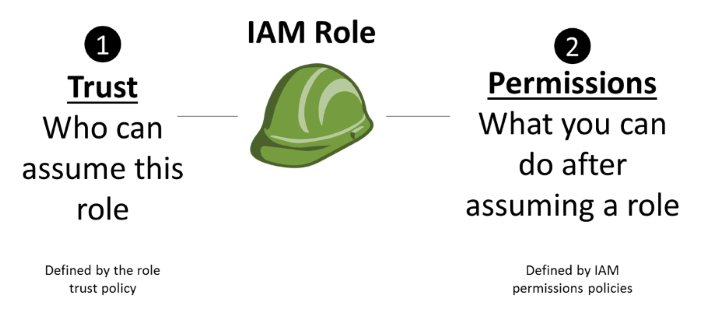

It is important to note that access keys, secret keys, and role ARN (Amazon Resource Names) are stored securely in a separate file and should not be hard coded into the scripts. To do this, environment variables are stored in a `.env` file and the `dotenv` library is used to load this variables within the scripts. This way, outside parties will not get any access that may breach the security of the AWS account. 

The following code initialize the AWS Security Token Service (STS) client for `bgg_user`.

```python
sts_client = boto3.client(
            'sts',
            aws_access_key_id = access_key,
            aws_secret_access_key= secret_key,
            region_name = aws_region,
        )
```

After initialization, the `bgg_user_role` is assigned to `bgg_user` in order to perform SQL queries using AWS Athena to access S3 buckets.

```python
assumed_role = sts_client.assume_role(
            RoleArn=role_arn,
            RoleSessionName='BGGRoleSession',
            DurationSeconds=18000,
        )
```

It can be noted that though the maximum session duration of 8 hours is allowed, only 5 hours was set as defined in the method call above.

### AWS Cloudwatch

During the development of the data pipeline, AWS CloudWatch collects and monitors logs originating from utilized services such as AWS Lambda and Glue. These logs serve to trace errors that occurred during tasks that either didn't execute as anticipated or failed to complete certain operations. Below is an example of such logs.

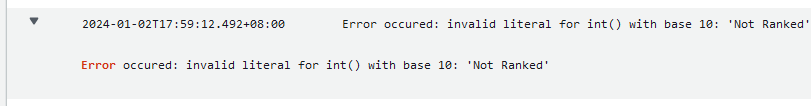

## Data Analysis/Machine Learning

### AWS Athena

Exploratory data analysis and machine learning tasks were conducted within a Jupyter Notebook environment, leveraging datasets extracted via AWS Athena. AWS Athena facilitates data retrieval from the data lake by utilizing table metadata stored in the Glue Data Catalog. As a serverless solution, it enables users to execute SQL-like queries without the need to manage infrastructure, offering seamless scalability based on query complexity.

It's crucial to highlight that proper data partitioning is vital for optimizing AWS Athena's efficiency. Additionally, it's important to note that AWS Athena is exclusively designed for querying datasets and lacks Data Manipulation Language (DML) capabilities.

The notebooks on EDA and Machine Learning conducted in this project are located in the `notebooks` folder of this repostory.

## Visualization

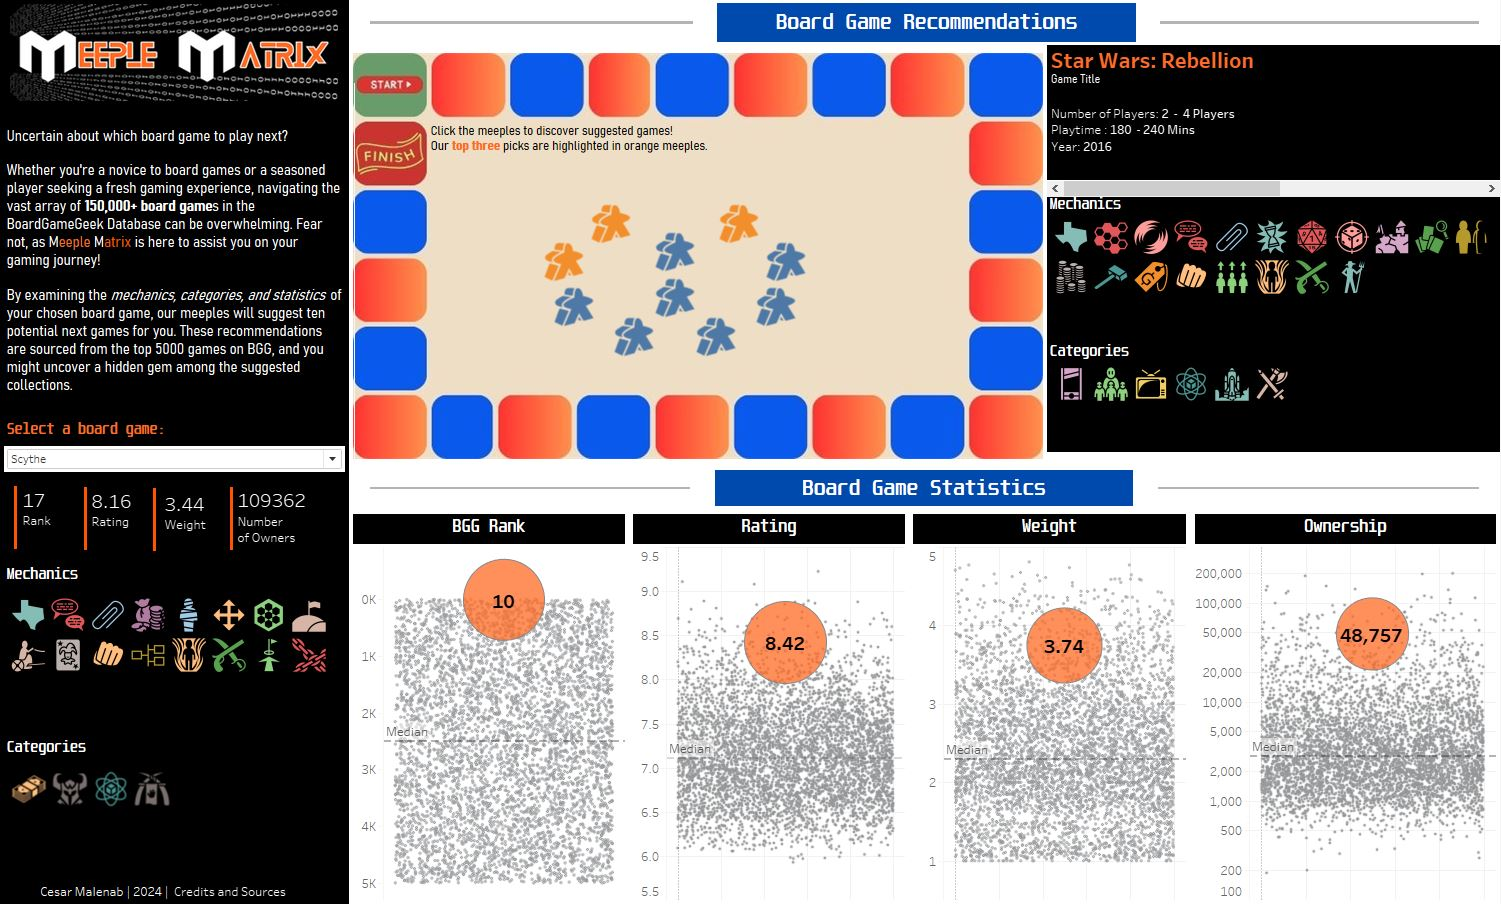


The Tableau dashboard depicted above acts as the user interface for the data pipeline, enabling users to choose a specific board game. Upon selection, the top 10 recommendations are displayed using meeples, with the top 3 games highlighted in orange. The recommendation model focuses on identifying similar games based on similarity scores derived from the games' mechanics and categories. Additionally, icons representing the mechanics and categories for the selected game are displayed.

Furthermore, the dashboard includes board game statistics such as rank, rating, complexity, and ownership count, presented in the jitter plot below. In this plot, gray dots represent all top 5000 board games used in the analysis while the orange circles provide details pertaining to the statistics of the currently selected recommendation.

To interact with the dashboard and explore its features, kindly access the visualization on this [page](https://public.tableau.com/app/profile/cesar.malenab/viz/BoardGameGeek_2/Dashboard1).

---